In [1]:
# =========================================================
# 1. IMPORT LIBRARIES
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# =========================================================
# 2. LOAD DATA
# =========================================================
df = pd.read_excel("data_bersih.xlsx")

target = "stress_level"
y = df[target]
X = df.drop(columns=[target])

# Tentukan kolom numerik
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [4]:
#Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 3B. Log Transform (AMAN, TANPA WARNING)
X_safe = X.copy()

# Shift semua nilai negatif / kurang dari -1 agar log1p tidak error
for col in X_safe.columns:
    mn = X_safe[col].min()
    if mn <= -1:
        X_safe[col] = X_safe[col] + abs(mn) + 1  # geser agar semua nilai >= 0

# Terapkan log1p
X_log = np.log1p(X_safe)
X_log.columns = [f"log_{c}" for c in X.columns]

# =========================================================
# 3C. Polynomial & Interaction Features (fix version)
# =========================================================
from sklearn.preprocessing import PolynomialFeatures

#  Fit polynomial features on ORIGINAL dataframe X
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_np = poly.fit_transform(X)   # gunakan X, bukan X_scaled

#  Ambil nama fitur baru
poly_feature_names = poly.get_feature_names_out(X.columns)

#  Buat dataframe
X_poly = pd.DataFrame(X_poly_np, columns=[f"poly_{n}" for n in poly_feature_names])

print("Bentuk fitur polynomial:", X_poly.shape)
X_poly.head()

#3D Interaction Feature
interaction_features = {}
for col1 in X.columns:
    for col2 in X.columns:
        if col1 != col2:
            interaction_features[f"{col1}_x_{col2}"] = X[col1] * X[col2]
            interaction_features[f"{col1}_div_{col2}"] = X[col1] / (X[col2] + 1)

X_interaction = pd.DataFrame(interaction_features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])


Bentuk fitur polynomial: (1100, 230)


In [5]:
# =========================================================
# 4. GABUNGKAN SEMUA FITUR
# =========================================================
df_FE = pd.concat([
    X,
    X_scaled,
    X_log,
    X_poly,
    X_interaction,
    df_pca
], axis=1)

df_FE[target] = y  # tambahkan target

In [6]:
# =========================================================
# 5. FEATURE SELECTION (RANDOM FOREST)
# =========================================================
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(df_FE.drop(columns=[target]), y)

selector = SelectFromModel(rf, prefit=True)
selected_mask = selector.get_support()
selected_features = df_FE.drop(columns=[target]).columns[selected_mask].tolist()

print("\nFitur Terpilih Random Forest:")
for f in selected_features:
    print("-", f)


Fitur Terpilih Random Forest:
- poly_anxiety_level basic_needs
- poly_anxiety_level future_career_concerns
- poly_depression study_load
- poly_depression bullying
- poly_noise_level future_career_concerns
- poly_safety future_career_concerns
- poly_academic_performance teacher_student_relationship
- anxiety_level_div_headache
- anxiety_level_div_sleep_quality
- anxiety_level_div_future_career_concerns
- self_esteem_x_anxiety_level
- self_esteem_div_headache
- self_esteem_div_blood_pressure
- self_esteem_div_sleep_quality
- self_esteem_div_future_career_concerns
- self_esteem_div_social_support
- self_esteem_div_peer_pressure
- self_esteem_div_bullying
- mental_health_history_div_headache
- mental_health_history_div_sleep_quality
- depression_div_headache
- depression_div_sleep_quality
- depression_div_living_conditions
- depression_div_academic_performance
- depression_x_study_load
- depression_div_future_career_concerns
- depression_div_social_support
- headache_div_sleep_quality
- h

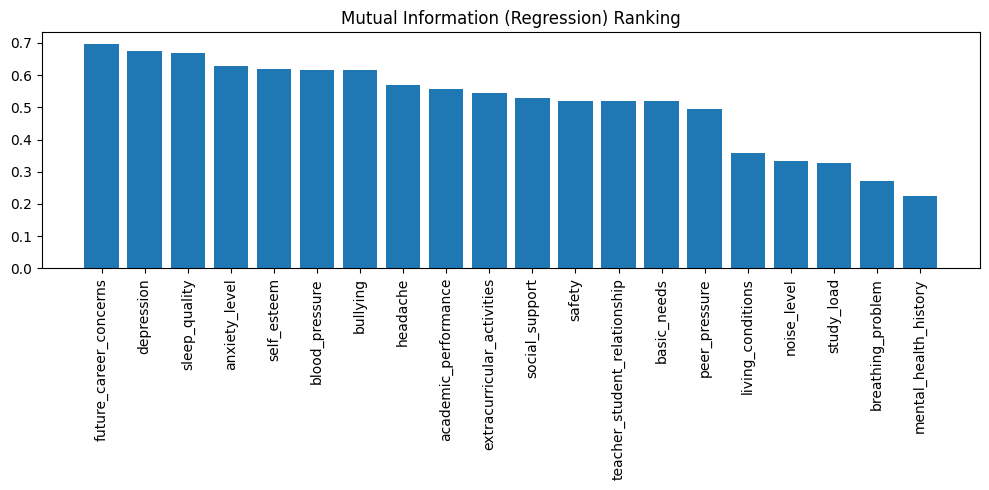

In [7]:
# =========================================================
# 6. MUTUAL INFORMATION (REGRESSION)
# =========================================================
mi_scores = mutual_info_regression(X[numeric_cols], y, random_state=42)
mi_series = pd.Series(mi_scores, index=numeric_cols).sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(mi_series.index, mi_series.values)
plt.title("Mutual Information (Regression) Ranking")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

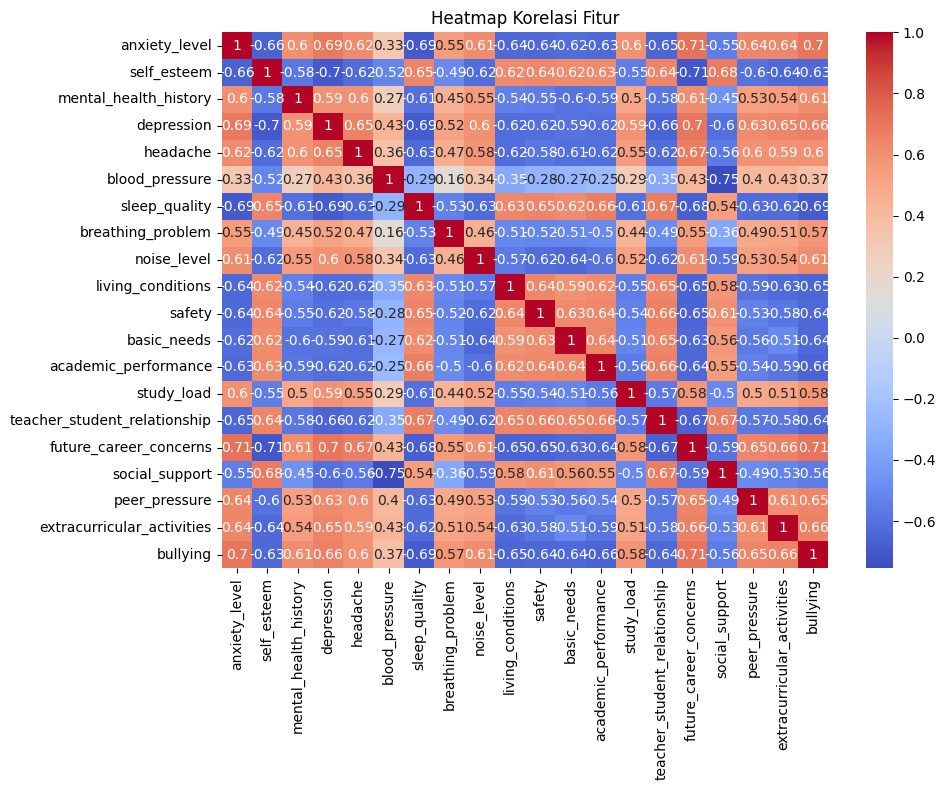

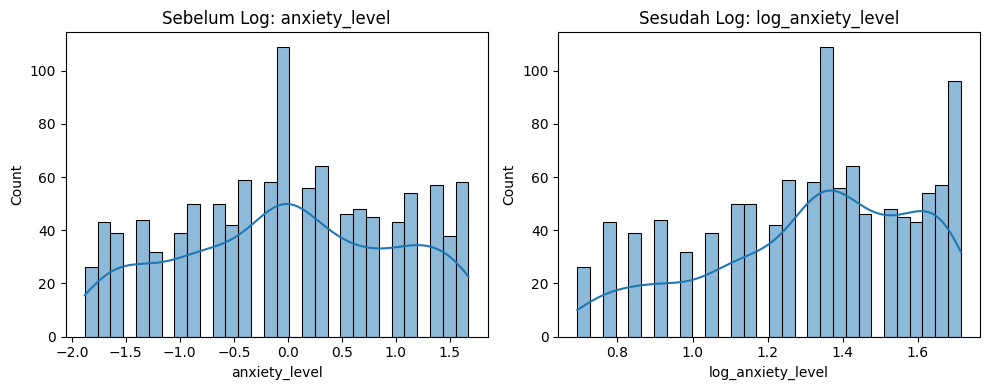

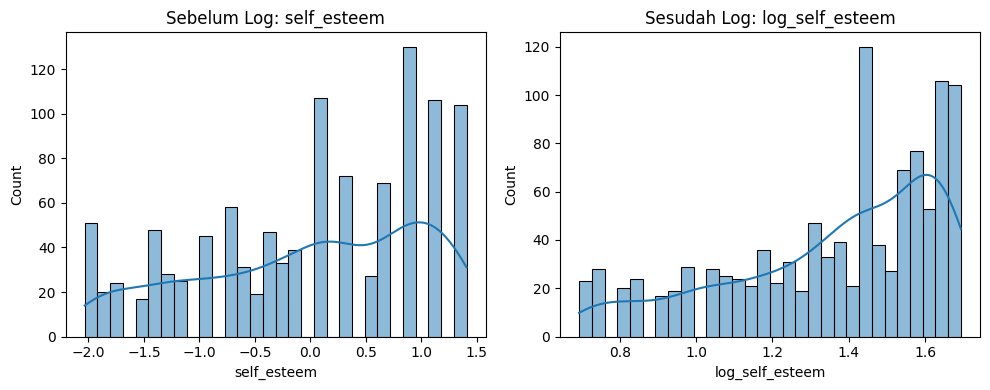

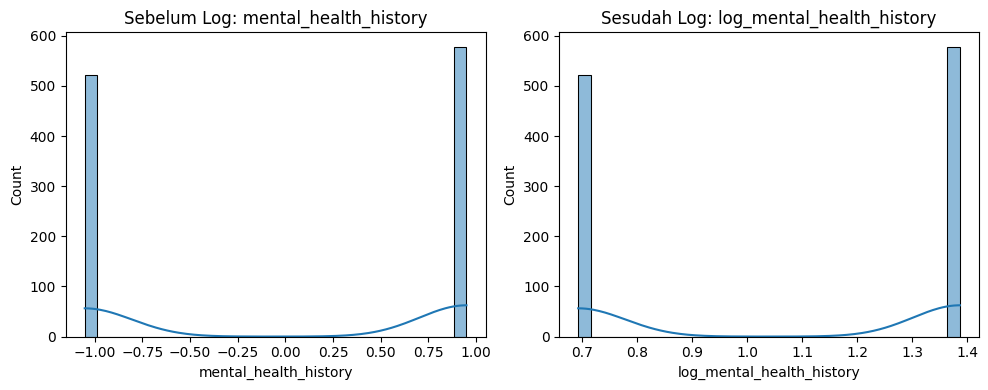

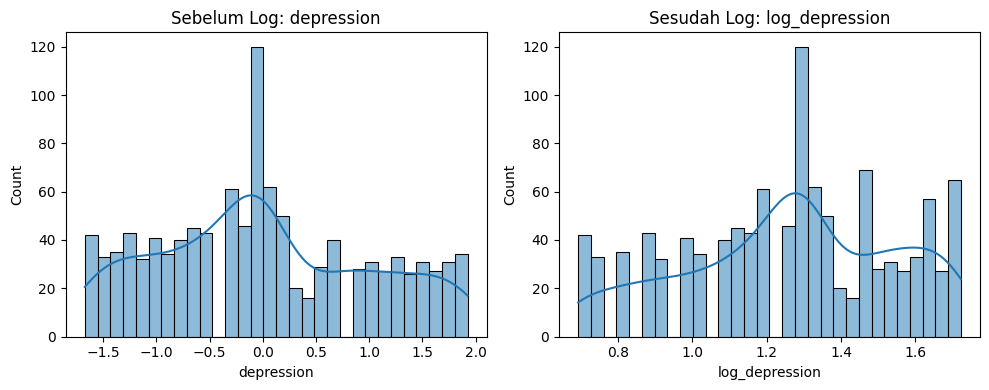

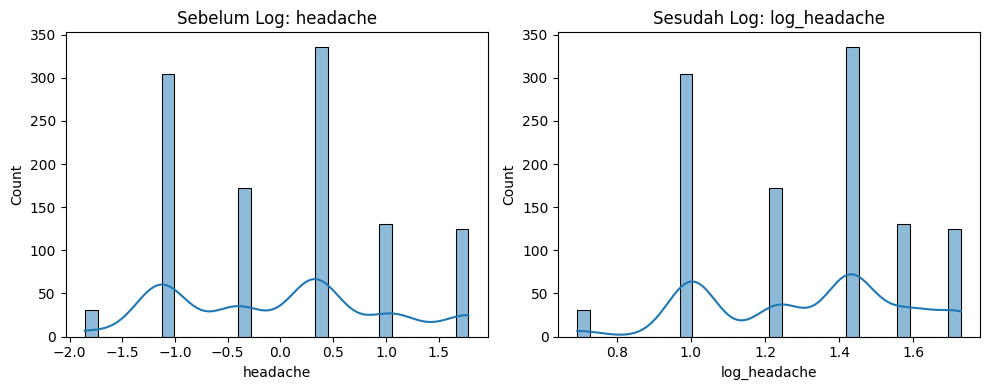

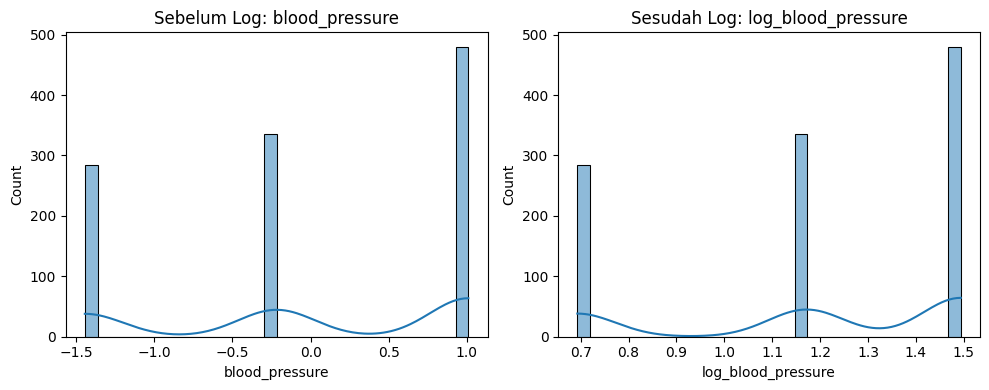

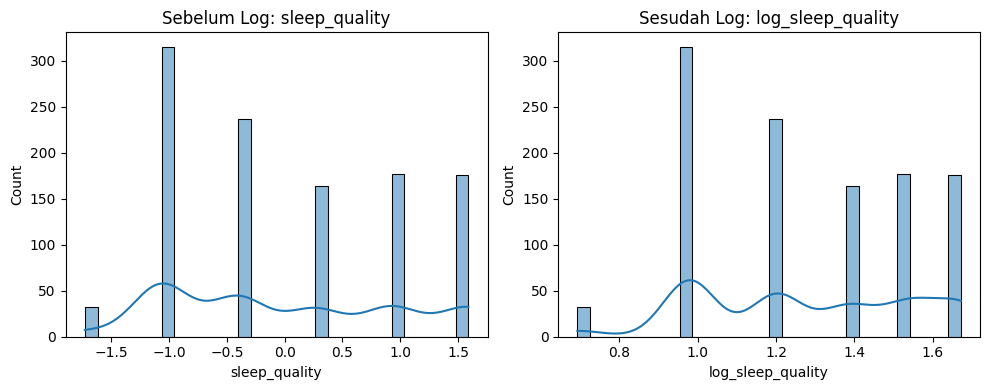

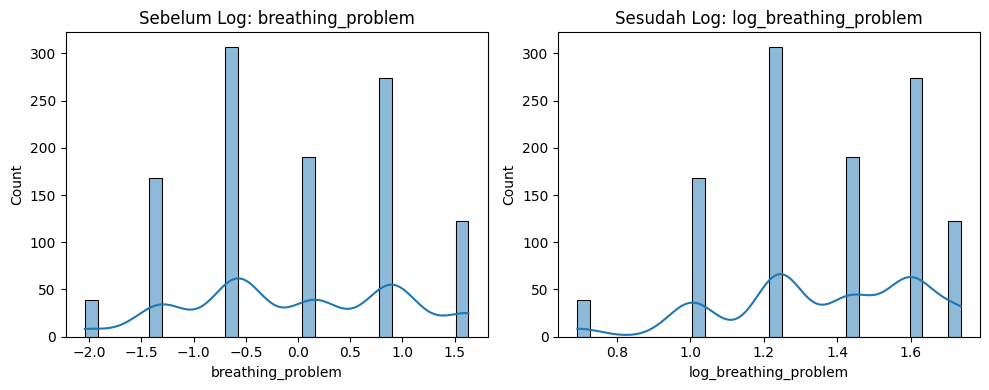

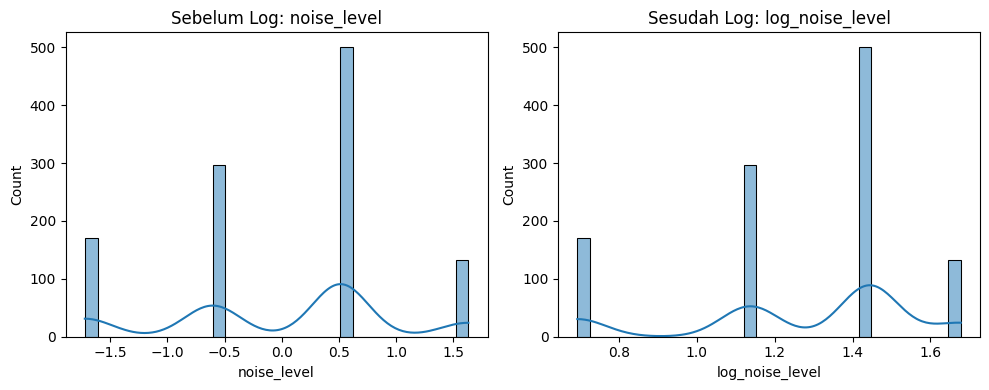

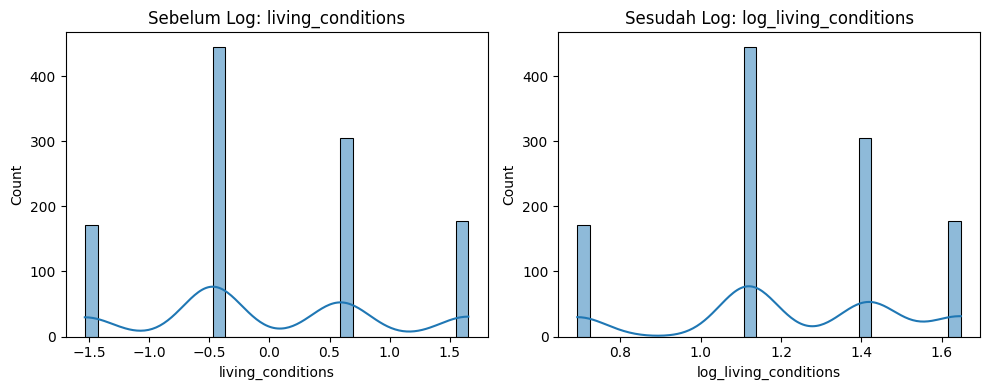

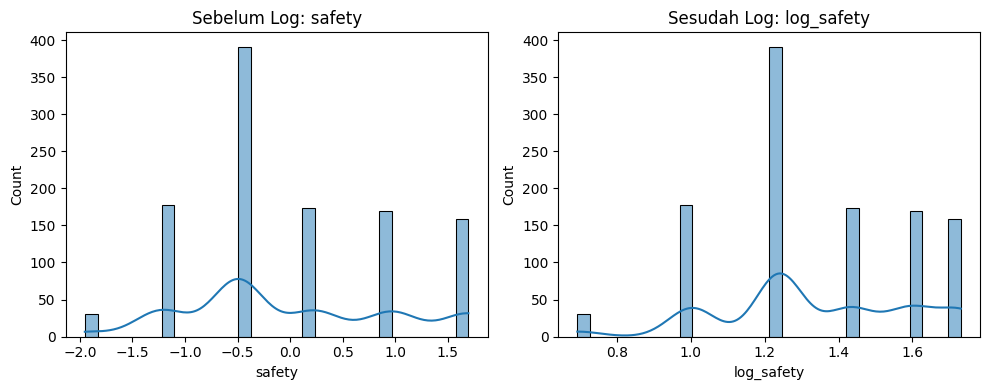

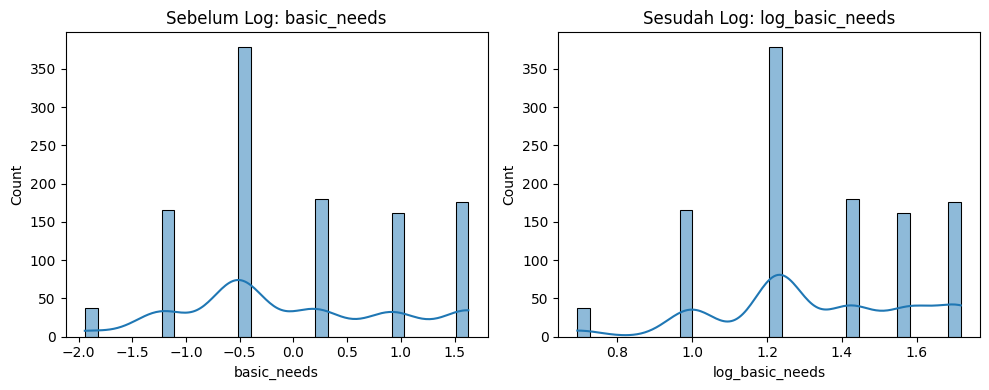

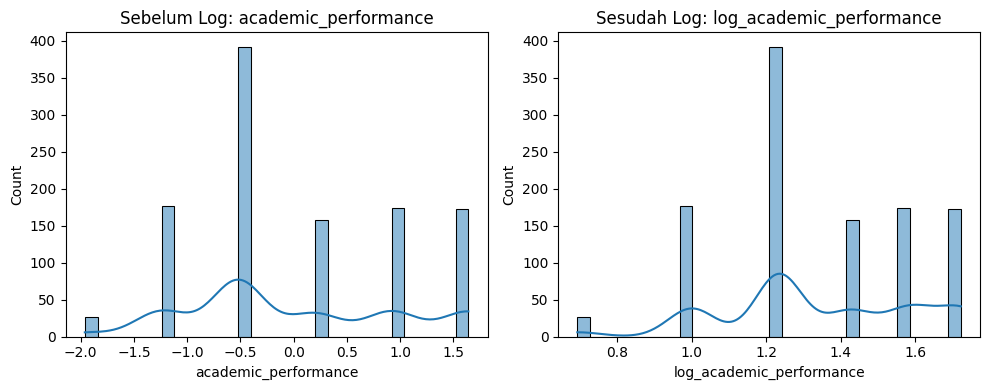

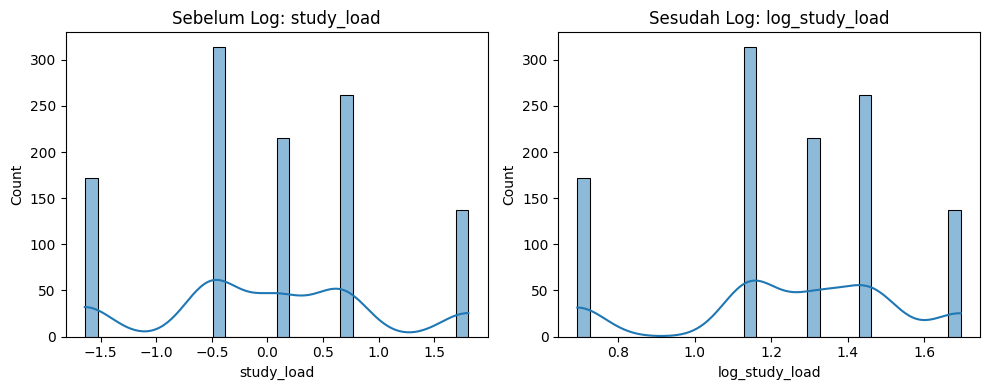

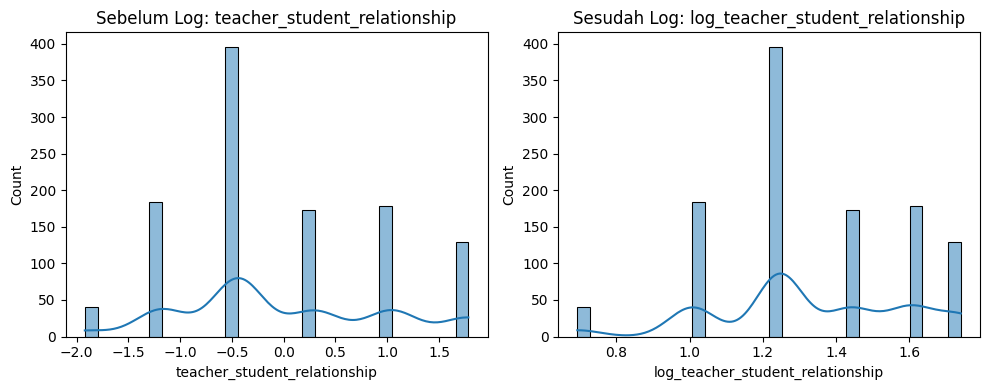

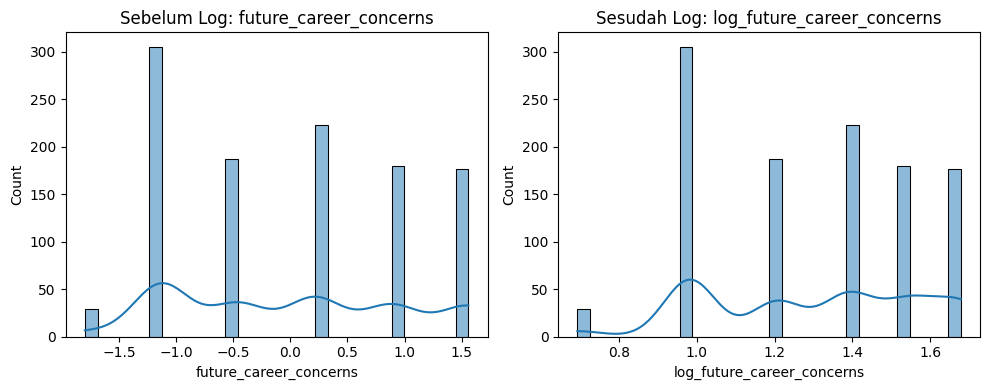

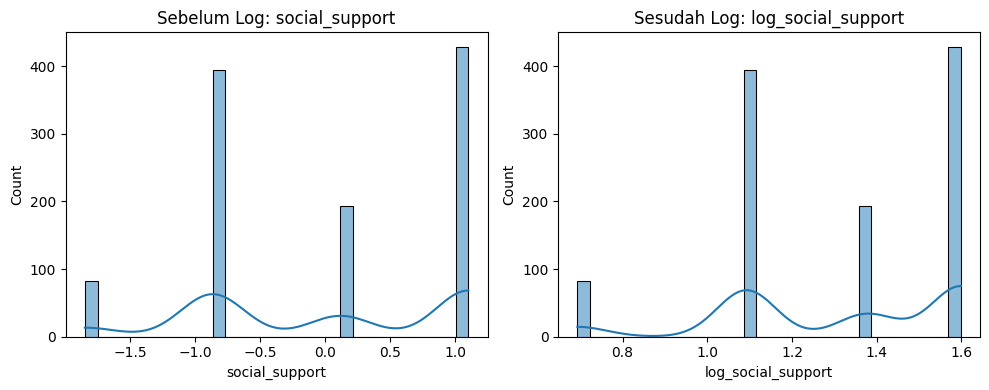

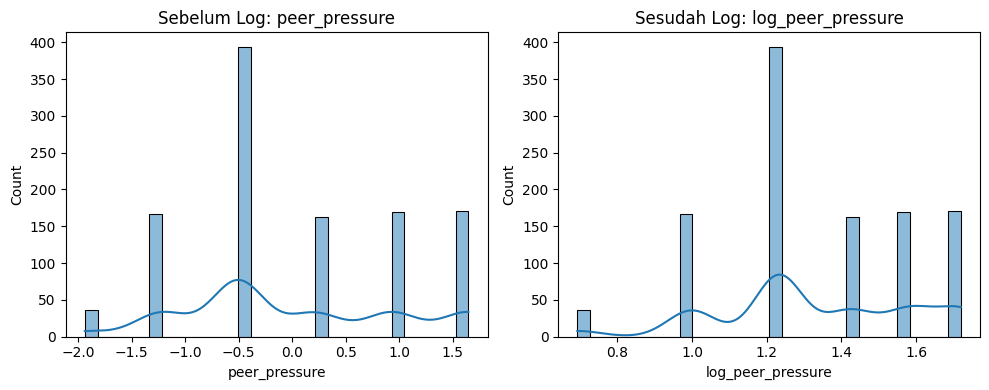

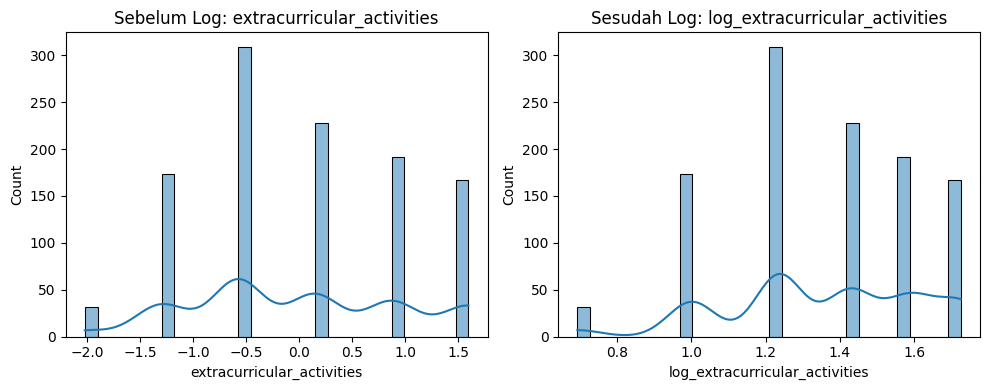

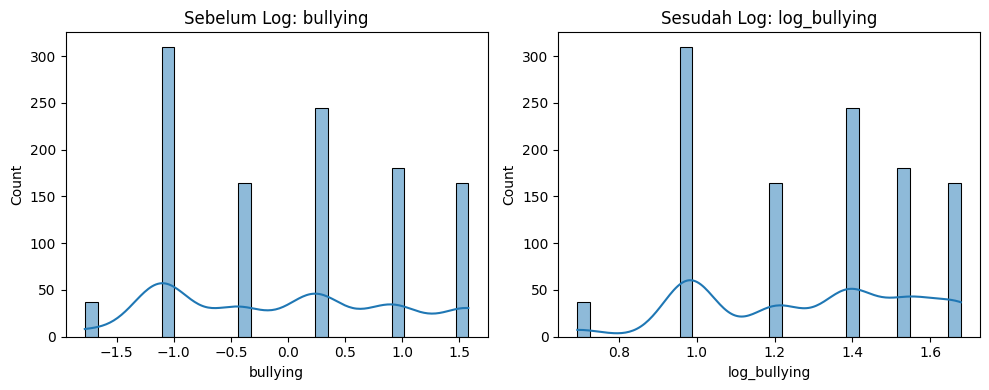

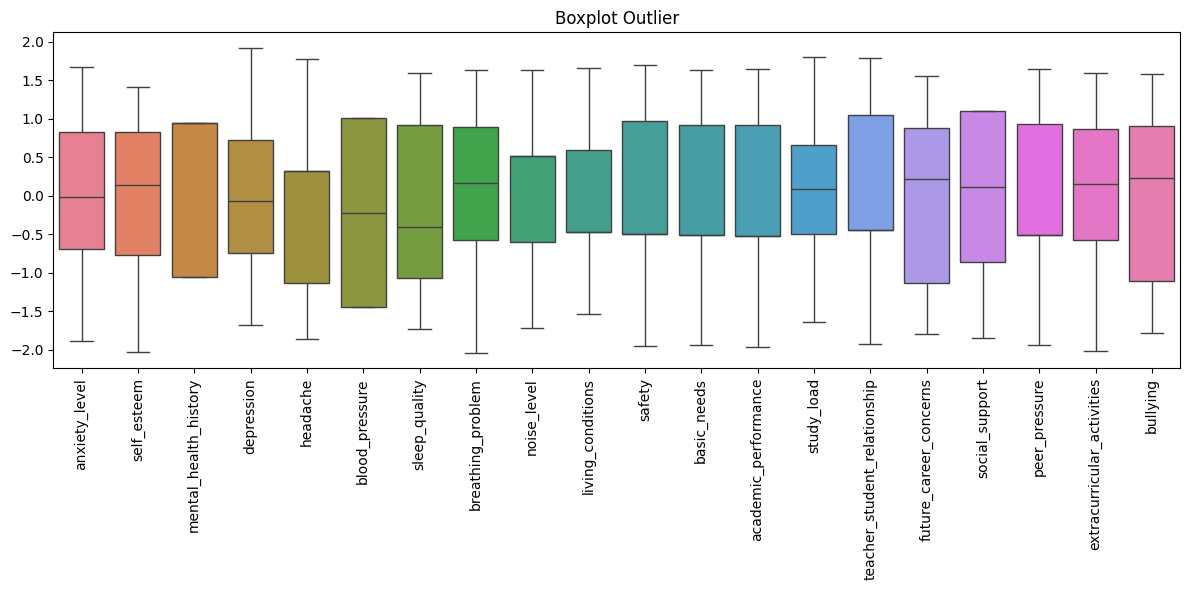

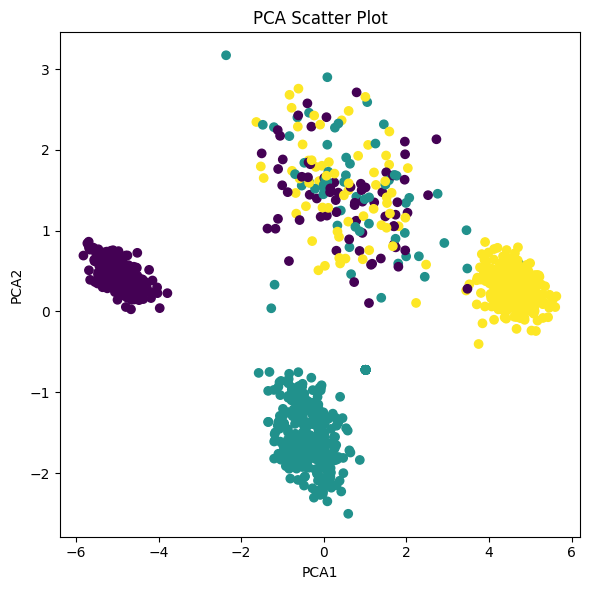

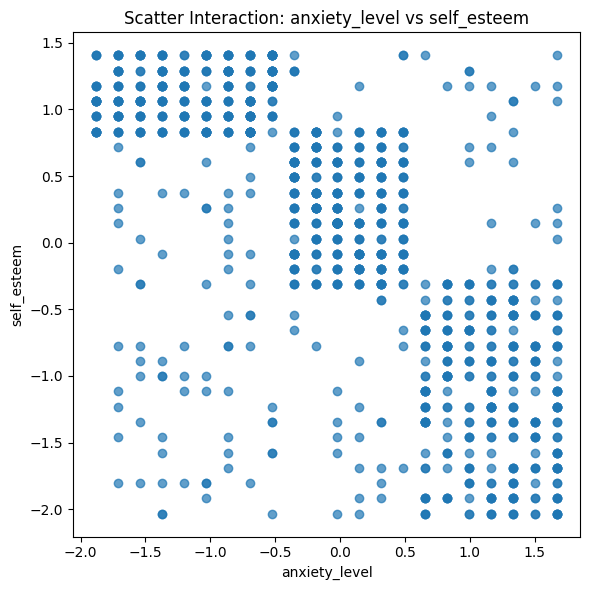

In [8]:
# =========================================================
# 7. VISUALISASI PREPROCESSING & FE
# =========================================================

# 7A. Heatmap Korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur")
plt.tight_layout()
plt.show()

# 7B. Distribusi Before & After Log
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Sebelum Log: {col}")

    plt.subplot(1, 2, 2)
    sns.histplot(X_log[f"log_{col}"], bins=30, kde=True)
    plt.title(f"Sesudah Log: log_{col}")

    plt.tight_layout()
    plt.show()

# 7C. Boxplot Outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot Outlier")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 7D. PCA Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(df_pca["PCA1"], df_pca["PCA2"], c=y, cmap="viridis")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Scatter Plot")
plt.tight_layout()
plt.show()

# 7E. Interaction Scatter 2 fitur pertama
c1, c2 = numeric_cols[:2]
plt.figure(figsize=(6, 6))
plt.scatter(X[c1], X[c2], alpha=0.7)
plt.xlabel(c1)
plt.ylabel(c2)
plt.title(f"Scatter Interaction: {c1} vs {c2}")
plt.tight_layout()
plt.show()

In [9]:
# =========================================================
# 8. SIMPAN DATASET FE
# =========================================================
df_FE.to_excel("Dataset_FeatureEngineering.xlsx", index=False)
print("\nDataset FE lengkap berhasil disimpan sebagai Dataset_FeatureEngineering.xlsx")


Dataset FE lengkap berhasil disimpan sebagai Dataset_FeatureEngineering.xlsx
